In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk

import spacy 
from sklearn import metrics
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from collections import Counter
from nltk import word_tokenize, FreqDist
import re
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import GRU, Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from time import time

import glob


# In this Notebook

- Cleaning of video game 2016 sales data
- Cleaning of video game 2019 sales data
- Combination/updating of 2016 data to accomodate 2019 scrape



- Exploratory Data Analysis for video game sales data
    - Publisher breakdown
    - Genre breakdown
    - Critic score vs. global sales
    - Country breakdown

# About the Datasets

**2016 Video Game Sales Data**

Originally I pulled this dataset from Kaggle, linked below. This dataset uses web-scraping and beautiful soup to scrape around 20,000 video games and some data about each of them from vgchartz.com. 

https://www.kaggle.com/gregorut/videogamesales/downloads/videogamesales.zip/2

However, this dataset didn't contain any information on each game's reviews or critical acclaim. Fortunately, I was able to find a dataset that expanded on the work done above to include critic reviews and a few other useful features. This dataset is linked below.

https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings 

In [384]:
#Importing the dataset 

In [385]:
df_2016 = pd.read_csv('video_game_sales_with_ratings_10k.csv')

In [386]:
#Previewing the dataframe
df_2016.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [387]:
df_2016.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

Per the kaggle page linked above, here is a brief description of each feature included in the dataframe...

- Rank - Ranking of overall sales

- Name - The games name

- Platform - Platform of the games release (i.e. PC,PS4, etc.)

- Year - Year of the game's release

- Genre - Genre of the game

- Publisher - Publisher of the game

- NA_Sales - Sales in North America (in millions)

- EU_Sales - Sales in Europe (in millions)

- JP_Sales - Sales in Japan (in millions)

- Other_Sales - Sales in the rest of the world (in millions)

- Global_Sales - Total worldwide sales.

- Critic_score - Aggregate score compiled by Metacritic staff

- Critic_count - The number of critics used in coming up with the Critic_score

- User_score - Score by Metacritic's subscribers

- User_count - Number of users who gave the user_score

- Developer - Party responsible for creating the game

- Rating - The ESRB ratings

## Cleaning the Dataset

First, I must look for null values and check for appropriate data types

In [388]:
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       8137 non-null float64
Critic_Count       8137 non-null float64
User_Score         10015 non-null object
User_Count         7590 non-null float64
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [389]:
df_2016.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


In [390]:
#Getting rid of duplicates. Have to subset for platform here because several games have same name but different platform
df_no_dupes = df_2016.drop_duplicates(subset=['Name', 'Platform'])

In [391]:
len(df_no_dupes)

16714

Good- not too many duplicates in the dataset (only 5 games out of nearly 17,000). 

A good sign that this data will be clean enough for EDA and machine learning

**Handling Null Values**

In [392]:
# Checking null values
df_no_dupes.isnull().sum().sort_values(ascending=False)

User_Count         9128
Critic_Count       8581
Critic_Score       8581
Rating             6768
User_Score         6703
Developer          6622
Year_of_Release     268
Publisher            53
Genre                 1
Name                  1
Global_Sales          0
Other_Sales           0
JP_Sales              0
EU_Sales              0
NA_Sales              0
Platform              0
dtype: int64

In [393]:
df_no_dupes['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [394]:
# User score needs to be converted from an object to a float. 
# Also there are some nan values in this column which need to be removed
# There also are values currently listed as "tbd" which need to be replaced with blanks

df_no_dupes['User_Score'].fillna(0, inplace=True)


C:\Users\Alex\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [395]:
# Replacing tbds with nans
df_no_dupes['User_Score'] = df_no_dupes['User_Score'].replace('tbd', np.nan)

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [396]:
# Filling newly created nans with 0s
df_no_dupes['User_Score'].fillna(0, inplace=True)

In [397]:
# Finally converting all of our 0s to np.nans
df_no_dupes['User_Score'].replace(0, np.nan, inplace=True)

C:\Users\Alex\Anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [398]:
# Converting from object to float
df_no_dupes['User_Score'] = df_no_dupes['User_Score'].astype(float)

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [399]:
df_no_dupes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16714 entries, 0 to 16718
Data columns (total 16 columns):
Name               16713 non-null object
Platform           16714 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
Publisher          16661 non-null object
NA_Sales           16714 non-null float64
EU_Sales           16714 non-null float64
JP_Sales           16714 non-null float64
Other_Sales        16714 non-null float64
Global_Sales       16714 non-null float64
Critic_Score       8133 non-null float64
Critic_Count       8133 non-null float64
User_Score         7586 non-null float64
User_Count         7586 non-null float64
Developer          10092 non-null object
Rating             9946 non-null object
dtypes: float64(10), object(6)
memory usage: 2.2+ MB


In [400]:
df_no_dupes.isnull().sum().sort_values(ascending=False)

User_Count         9128
User_Score         9128
Critic_Count       8581
Critic_Score       8581
Rating             6768
Developer          6622
Year_of_Release     268
Publisher            53
Genre                 1
Name                  1
Global_Sales          0
Other_Sales           0
JP_Sales              0
EU_Sales              0
NA_Sales              0
Platform              0
dtype: int64

Looking at this, it seems like we can get rid of the the rows where the following features are null

- Year_of_Release
- Publisher
- Genre
- Name

This is only around 325 records so it shouldn't drastically affect our analysis

For the purposes of basic EDA, the following categories will be left in for now and edited for machine learning in a modeling notebook.

- User_Count
- User_Score
- Critic_Count
- Critic_Score
- Rating
- Developer

In [401]:
df_no_dupes[pd.isnull(df_no_dupes['Name'])]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
659,NaN,GEN,1993.0,NaN,Acclaim Entertainment,1.78,0.53,0.0,0.08,2.39,NaN,NaN,NaN,NaN,NaN,NaN


In [402]:
# Dropping the row without a name
df_no_dupes.drop(df_no_dupes[pd.isnull(df_no_dupes['Name'])].index, inplace=True)

C:\Users\Alex\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [403]:
# Dropping the row without genre
df_no_dupes.drop(df_no_dupes[pd.isnull(df_no_dupes['Genre'])].index, inplace=True)

In [404]:
# Instead of dropping the publisher rows, I decided to simply replace them with "unknown"
df_no_dupes['Publisher'].fillna('Unknown', inplace=True)

In [405]:
# Dropping games where year of release is blank (268 games)

df_no_dupes.dropna(subset=['Year_of_Release'], inplace=True)

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [406]:
df_no_dupes.isnull().sum().sort_values(ascending=False)

User_Count         8985
User_Score         8985
Critic_Count       8465
Critic_Score       8465
Rating             6679
Developer          6541
Global_Sales          0
Other_Sales           0
JP_Sales              0
EU_Sales              0
NA_Sales              0
Publisher             0
Genre                 0
Year_of_Release       0
Platform              0
Name                  0
dtype: int64

In [407]:
df_no_dupes.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

In [408]:
df_no_dupes['Critic_Score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

## Adding in 2019 Scraped Data

- As mentioned in the intro, the dataset above was scraped from vgchartz near the end of 2016. This dataset was subsequently updated by another user with a different scraping method. 
- Below I will combine the two datasets into one cohesive dataframe with information through early 2019

In [410]:
df_2019 = pd.read_csv('vgsales_cleaned_v3.csv')

In [411]:
df_2019.head()

,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,User_Score,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.86,NaN,NaN,NaN,NaN,7.7,NaN,Nintendo EAD,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,NaN,NaN,NaN,NaN,10.0,NaN,Nintendo EAD,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,37.14,NaN,NaN,NaN,NaN,8.2,9.1,Nintendo EAD,E
3,PlayerUnknown's Battlegrounds,PC,2017.0,Shooter,PUBG Corporation,36.60,NaN,NaN,NaN,NaN,NaN,NaN,PUBG Corporation,NaN
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.09,NaN,NaN,NaN,NaN,8.0,8.8,Nintendo EAD,E


In [412]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21242 entries, 0 to 21241
Data columns (total 14 columns):
Name               19862 non-null object
Platform           19862 non-null object
Year_of_Release    19859 non-null float64
Genre              19862 non-null object
Publisher          19862 non-null object
Global_Sales       19862 non-null float64
NA_Sales           12777 non-null float64
EU_Sales           12125 non-null float64
JP_Sales           6791 non-null float64
Other_Sales        14510 non-null float64
Critic_Score       4706 non-null float64
User_Score         238 non-null float64
Developer          19860 non-null object
Rating             13925 non-null object
dtypes: float64(8), object(6)
memory usage: 2.3+ MB


It appears that this dataset has more missing data than the originally scraped 2016 dataset. As such, I will only bring the following years over from the 2019 set.

- 2016 (because sales data from releases in 2016 likely carried over into 2017 and 2018.)
- 2017
- 2018

After some initial exploration, I decided to drop 2019 from the dataset because there was only data for 34 games released in 2019, and most of these were either just released or haven't been released yet. 

Below, I'll first add in 2017 and 2018 because it requires no updating, and then update the 2016 sales numbers to reflect what they were in 2019.

In [430]:
# Pulling just 2017 and 2018
updated_years_df = df_2019.loc[(df_2019['Year_of_Release'] >= 2017) & (df_2019['Year_of_Release'] < 2019)]

In [431]:
updated_years_df['Year_of_Release'].value_counts()

2017.0    784
2018.0    715
Name: Year_of_Release, dtype: int64

In [459]:
# Creating an update dataframe for 2016 data
updated_sales_df = df_2019.loc[(df_2019['Year_of_Release'] == 2016)]


In [464]:
len(updated_sales_df)

746

In [465]:
updated_sales_df['2019_Global_Sales'] = updated_sales_df['Global_Sales']

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [466]:
updated_sales_df['merge_name'] = updated_sales_df['Name'] + "_" + updated_sales_df['Platform']

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [468]:
merger_df = updated_sales_df[['merge_name', '2019_Global_Sales']]


In [469]:
#Combining the dataframes
df_list = [df_no_dupes, updated_years_df]

combined_df = pd.concat(df_list, axis=0)


C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [470]:
combined_df.head()

,Critic_Count,Critic_Score,Developer,EU_Sales,Genre,Global_Sales,JP_Sales,NA_Sales,Name,Other_Sales,Platform,Publisher,Rating,User_Count,User_Score,Year_of_Release
0,51.0,76.0,Nintendo,28.96,Sports,82.53,3.77,41.36,Wii Sports,8.45,Wii,Nintendo,E,322.0,8.0,2006.0
1,NaN,NaN,NaN,3.58,Platform,40.24,6.81,29.08,Super Mario Bros.,0.77,NES,Nintendo,NaN,NaN,NaN,1985.0
2,73.0,82.0,Nintendo,12.76,Racing,35.52,3.79,15.68,Mario Kart Wii,3.29,Wii,Nintendo,E,709.0,8.3,2008.0
3,73.0,80.0,Nintendo,10.93,Sports,32.77,3.28,15.61,Wii Sports Resort,2.95,Wii,Nintendo,E,192.0,8.0,2009.0
4,NaN,NaN,NaN,8.89,Role-Playing,31.37,10.22,11.27,Pokemon Red/Pokemon Blue,1.00,GB,Nintendo,NaN,NaN,NaN,1996.0


In [471]:
len(combined_df)

17944

In [472]:
# Creating a merge_name column to update 2016 sales numbers
combined_df['merge_name'] = combined_df['Name'] + "_" + combined_df['Platform']

In [473]:
combined_df.columns

Index(['Critic_Count', 'Critic_Score', 'Developer', 'EU_Sales', 'Genre',
       'Global_Sales', 'JP_Sales', 'NA_Sales', 'Name', 'Other_Sales',
       'Platform', 'Publisher', 'Rating', 'User_Count', 'User_Score',
       'Year_of_Release', 'merge_name'],
      dtype='object')

In [474]:
# Merging in updated sales data
combined_df = combined_df.merge(merger_df,how='left',on='merge_name')

In [480]:
len(combined_df)

17946

In [476]:
combined_df.columns

Index(['Critic_Count', 'Critic_Score', 'Developer', 'EU_Sales', 'Genre',
       'Global_Sales', 'JP_Sales', 'NA_Sales', 'Name', 'Other_Sales',
       'Platform', 'Publisher', 'Rating', 'User_Count', 'User_Score',
       'Year_of_Release', 'merge_name', '2019_Global_Sales'],
      dtype='object')

In [496]:
combined_df.count().sort_values(ascending=False)

2019_Global_Sales    17946
Publisher            17946
Genre                17946
Global_Sales         17946
merge_name           17946
Platform             17946
Name                 17946
Year_of_Release      17946
Other_Sales          17483
NA_Sales             17399
JP_Sales             17067
EU_Sales             17012
Developer            11405
Rating               10688
Critic_Score          8202
Critic_Count          7982
User_Score            7500
User_Count            7462
dtype: int64

In [485]:
combined_df.loc[(combined_df['2019_Global_Sales'] != 0) &(combined_df['Year_of_Release'] == 2016)]

,Critic_Count,Critic_Score,Developer,EU_Sales,Genre,Global_Sales,JP_Sales,NA_Sales,Name,Other_Sales,Platform,Publisher,Rating,User_Count,User_Score,Year_of_Release,merge_name,2019_Global_Sales
94,41.0,85.0,"EA Sports, EA Vancouver",5.75,Sports,7.59,0.08,0.66,FIFA 17,1.11,PS4,Electronic Arts,E,398.0,5.0,2016.0,FIFA 17_PS4,10.94
108,NaN,NaN,NaN,1.45,Role-Playing,7.14,2.26,2.98,Pokemon Sun/Moon,0.45,3DS,Nintendo,NaN,NaN,NaN,2016.0,Pokemon Sun/Moon_3DS,16.14
171,113.0,93.0,Naughty Dog,2.50,Shooter,5.38,0.19,1.85,Uncharted 4: A Thief's End,0.85,PS4,Sony Computer Entertainment,T,7064.0,7.9,2016.0,Uncharted 4: A Thief's End_PS4,8.70
244,82.0,77.0,Infinity Ward,2.00,Shooter,4.46,0.15,1.61,Call of Duty: Infinite Warfare,0.71,PS4,Activision,M,1129.0,3.4,2016.0,Call of Duty: Infinite Warfare_PS4,8.48
288,31.0,88.0,EA DICE,2.15,Shooter,4.08,0.21,1.10,Battlefield 1,0.61,PS4,Electronic Arts,M,809.0,8.4,2016.0,Battlefield 1_PS4,7.26
324,64.0,80.0,Massive Entertainment,1.70,Shooter,3.80,0.15,1.35,Tom Clancy's The Division,0.60,PS4,Ubisoft,M,2219.0,7.0,2016.0,Tom Clancy's The Division_PS4,4.37
567,50.0,84.0,"EA Sports, EA Vancouver",2.05,Sports,2.65,0.00,0.43,FIFA 17,0.17,XOne,Electronic Arts,E,201.0,5.5,2016.0,FIFA 17_XOne,3.71
634,17.0,78.0,Infinity Ward,0.74,Shooter,2.42,0.00,1.46,Call of Duty: Infinite Warfare,0.22,XOne,Activision,M,290.0,3.1,2016.0,Call of Duty: Infinite Warfare_XOne,4.79
699,91.0,76.0,Ubisoft Montreal,1.25,Action,2.26,0.06,0.60,Far Cry: Primal,0.35,PS4,Ubisoft,M,635.0,6.3,2016.0,Far Cry: Primal_PS4,2.73
700,37.0,87.0,EA DICE,0.77,Shooter,2.25,0.00,1.28,Battlefield 1,0.20,XOne,Electronic Arts,M,440.0,8.2,2016.0,Battlefield 1_XOne,5.13


In [486]:
# Putting 0s in for all games that were not updated for 2019 numbers
combined_df['2019_Global_Sales'].fillna(0, inplace=True)

In [491]:
# Replacing the global sales numbers from the 2016 set with the updated number from the 2019 set
combined_df.loc[combined_df['2019_Global_Sales'] != 0, 'Global_Sales'] = combined_df['2019_Global_Sales']

In [495]:
# Checking to see if it worked
combined_df.loc[combined_df['Year_of_Release'] == 2016].sort_values('Global_Sales', ascending=False)

,Critic_Count,Critic_Score,Developer,EU_Sales,Genre,Global_Sales,JP_Sales,NA_Sales,Name,Other_Sales,Platform,Publisher,Rating,User_Count,User_Score,Year_of_Release,merge_name,2019_Global_Sales
108,NaN,NaN,NaN,1.45,Role-Playing,16.14,2.26,2.98,Pokemon Sun/Moon,0.45,3DS,Nintendo,NaN,NaN,NaN,2016.0,Pokemon Sun/Moon_3DS,16.14
94,41.0,85.0,"EA Sports, EA Vancouver",5.75,Sports,10.94,0.08,0.66,FIFA 17,1.11,PS4,Electronic Arts,E,398.0,5.0,2016.0,FIFA 17_PS4,10.94
171,113.0,93.0,Naughty Dog,2.50,Shooter,8.70,0.19,1.85,Uncharted 4: A Thief's End,0.85,PS4,Sony Computer Entertainment,T,7064.0,7.9,2016.0,Uncharted 4: A Thief's End_PS4,8.70
244,82.0,77.0,Infinity Ward,2.00,Shooter,8.48,0.15,1.61,Call of Duty: Infinite Warfare,0.71,PS4,Activision,M,1129.0,3.4,2016.0,Call of Duty: Infinite Warfare_PS4,8.48
288,31.0,88.0,EA DICE,2.15,Shooter,7.26,0.21,1.10,Battlefield 1,0.61,PS4,Electronic Arts,M,809.0,8.4,2016.0,Battlefield 1_PS4,7.26
700,37.0,87.0,EA DICE,0.77,Shooter,5.13,0.00,1.28,Battlefield 1,0.20,XOne,Electronic Arts,M,440.0,8.2,2016.0,Battlefield 1_XOne,5.13
634,17.0,78.0,Infinity Ward,0.74,Shooter,4.79,0.00,1.46,Call of Duty: Infinite Warfare,0.22,XOne,Activision,M,290.0,3.1,2016.0,Call of Duty: Infinite Warfare_XOne,4.79
757,31.0,90.0,Blizzard Entertainment,0.85,Shooter,4.54,0.15,0.81,Overwatch,0.33,PS4,Activision,T,1358.0,6.1,2016.0,Overwatch_PS4,4.54
324,64.0,80.0,Massive Entertainment,1.70,Shooter,4.37,0.15,1.35,Tom Clancy's The Division,0.60,PS4,Ubisoft,M,2219.0,7.0,2016.0,Tom Clancy's The Division_PS4,4.37
567,50.0,84.0,"EA Sports, EA Vancouver",2.05,Sports,3.71,0.00,0.43,FIFA 17,0.17,XOne,Electronic Arts,E,201.0,5.5,2016.0,FIFA 17_XOne,3.71


Success! I've updated all of the 2016 games with their 2019 numbers.

**Handling Regional Sales Data Nulltypes**

Upon scanning the data, it appears that most of the regional sales data is complete, but certain rows are missing ALL of the regional data. Below I will count how many rows have NaN in all of the regional sales fields

In [478]:
# Previewing 
combined_df.loc[(pd.isnull(combined_df['NA_Sales'])) & (pd.isnull(combined_df['JP_Sales'])) & (pd.isnull(combined_df['EU_Sales']))]

,Critic_Count,Critic_Score,Developer,EU_Sales,Genre,Global_Sales,JP_Sales,NA_Sales,Name,Other_Sales,Platform,Publisher,Rating,User_Count,User_Score,Year_of_Release,merge_name,2019_Global_Sales
16447,NaN,NaN,PUBG Corporation,NaN,Shooter,36.60,NaN,NaN,PlayerUnknown's Battlegrounds,NaN,PC,PUBG Corporation,NaN,NaN,NaN,2017.0,PlayerUnknown's Battlegrounds_PC,NaN
16448,NaN,9.3,Nintendo EPD,NaN,Racing,15.02,NaN,NaN,Mario Kart 8 Deluxe,NaN,NS,Nintendo,E,NaN,NaN,2017.0,Mario Kart 8 Deluxe_NS,NaN
16450,NaN,9.9,Nintendo EPD,NaN,Platform,13.76,NaN,NaN,Super Mario Odyssey,NaN,NS,Nintendo,E10,NaN,NaN,2017.0,Super Mario Odyssey_NS,NaN
16452,NaN,9.4,Bandai Namco Games,NaN,Fighting,12.08,NaN,NaN,Super Smash Bros. Ultimate,NaN,NS,Nintendo,E10,NaN,9.7,2018.0,Super Smash Bros. Ultimate_NS,NaN
16454,NaN,9.9,Nintendo EPD,NaN,Action-Adventure,11.68,NaN,NaN,The Legend of Zelda: Breath of the Wild,NaN,NS,Nintendo,E10,NaN,10.0,2017.0,The Legend of Zelda: Breath of the Wild_NS,NaN
16455,NaN,NaN,Game Freak,NaN,Role-Playing,10.00,NaN,NaN,"Pokemon: Let's Go, Pikachu/Eevee",NaN,NS,Nintendo,E,NaN,NaN,2018.0,"Pokemon: Let's Go, Pikachu/Eevee_NS",NaN
16456,NaN,9.1,Guerrilla Games,NaN,Action,10.00,NaN,NaN,Horizon: Zero Dawn,NaN,PS4,Sony Interactive Entertainment,T,NaN,8.0,2017.0,Horizon: Zero Dawn_PS4,NaN
16459,NaN,6.1,Facepunch Studios,NaN,Action-Adventure,9.15,NaN,NaN,Rust,NaN,PC,Facepunch Studios,NaN,NaN,NaN,2018.0,Rust_PC,NaN
16460,NaN,9.1,Insomniac Games,NaN,Action-Adventure,9.00,NaN,NaN,Marvel's Spider-Man,NaN,PS4,Sony Interactive Entertainment,T,NaN,NaN,2018.0,Marvel's Spider-Man_PS4,NaN
16461,NaN,8.1,Game Freak,NaN,Role-Playing,8.28,NaN,NaN,Pokemon: Ultra Sun and Ultra Moon,NaN,3DS,Nintendo,E,NaN,NaN,2017.0,Pokemon: Ultra Sun and Ultra Moon_3DS,NaN


In [497]:
# Counting how many games have null values for all regional data
len(combined_df.loc[(pd.isnull(combined_df['NA_Sales'])) & (pd.isnull(combined_df['JP_Sales'])) & (pd.isnull(combined_df['EU_Sales'])) & (pd.isnull(combined_df['Other_Sales']))])

154

Only 154 instances where all 4 regional sales fields are blank. This is not too many, and I decided to drop these pieces of data.

In [498]:
# Dropping
items_to_drop = combined_df.loc[(pd.isnull(combined_df['NA_Sales'])) & (pd.isnull(combined_df['JP_Sales'])) & (pd.isnull(combined_df['EU_Sales'])) & (pd.isnull(combined_df['Other_Sales']))]

combined_df.drop(items_to_drop.index, inplace=True)

In [499]:
# Making sure it worked
len(combined_df.loc[(pd.isnull(combined_df['NA_Sales'])) & (pd.isnull(combined_df['JP_Sales'])) & (pd.isnull(combined_df['EU_Sales'])) & (pd.isnull(combined_df['Other_Sales']))])

0

In [500]:
combined_df.isnull().sum().sort_values(ascending=False)

User_Count           10330
User_Score           10301
Critic_Count          9810
Critic_Score          9620
Rating                7177
Developer             6541
EU_Sales               780
JP_Sales               725
NA_Sales               393
Other_Sales            309
Global_Sales             0
Genre                    0
2019_Global_Sales        0
merge_name               0
Platform                 0
Publisher                0
Year_of_Release          0
Name                     0
dtype: int64

Still need to fill the Nans for regional sales data in with 0s. By scanning the data, I confirmed that NaNs are just placeholders for 0s. In other words, many games only sell in certain regions (e.g. games only launched in Japan) and therefore have no sales outside of that region. In this example, Japan sales = Global Sales. 

In [501]:
# Replacing NaNs in regional columns with 0s
combined_df['NA_Sales'].fillna(0, inplace=True)
combined_df['JP_Sales'].fillna(0, inplace=True)
combined_df['EU_Sales'].fillna(0, inplace=True)
combined_df['Other_Sales'].fillna(0, inplace=True)

In [502]:
combined_df.isnull().sum().sort_values(ascending=False)

User_Count           10330
User_Score           10301
Critic_Count          9810
Critic_Score          9620
Rating                7177
Developer             6541
JP_Sales                 0
EU_Sales                 0
Genre                    0
Global_Sales             0
2019_Global_Sales        0
NA_Sales                 0
merge_name               0
Other_Sales              0
Platform                 0
Publisher                0
Year_of_Release          0
Name                     0
dtype: int64

In [503]:
# Reorders the dataframe so it's not out of order. For whatever reason pd.concat sorts columns alphabetically unless
# the dataset is re-indexed
combined_df2 = combined_df.reindex_axis(df_no_dupes.columns, axis=1)

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [504]:
combined_df2.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [505]:
combined_df2.isnull().sum().sort_values(ascending=False)

User_Count         10330
User_Score         10301
Critic_Count        9810
Critic_Score        9620
Rating              7177
Developer           6541
Global_Sales           0
Other_Sales            0
JP_Sales               0
EU_Sales               0
NA_Sales               0
Publisher              0
Genre                  0
Year_of_Release        0
Platform               0
Name                   0
dtype: int64

In [506]:
combined_df2['Year_of_Release'].value_counts(ascending=False)

2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     938
2002.0     829
2003.0     775
2004.0     762
2017.0     691
2018.0     657
2012.0     651
2015.0     608
2014.0     581
2013.0     544
2016.0     502
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      60
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1990.0      16
1987.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
2020.0       1
Name: Year_of_Release, dtype: int64

In [516]:
# Noticed there's a 2020 still in the dataset. Removed here.
combined_df2.drop(combined_df2.loc[combined_df2['Year_of_Release'] == 2020].index, inplace=True)

In [517]:
# Making sure it's gone
combined_df2.loc[combined_df2['Year_of_Release'] == 2020]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating


**The data is finally looking good for visualizing and exploratory data analysis. The null values in the dataframe above will be dealt with when the data is preprocessed for machine learning**

## Exploratory Data Analysis

First, I want to examine the number of games released in each year. This project is primarily focused on the modern age of commercial video-gaming. Below I'll do some EDA to determine when the age started.

In [518]:
year_count = combined_df2.groupby('Year_of_Release', axis=0).count().reset_index()[['Year_of_Release','Name']]

In [519]:
year_count

,Year_of_Release,Name
0,1980.0,9
1,1981.0,46
2,1982.0,36
3,1983.0,17
4,1984.0,14
5,1985.0,14
6,1986.0,21
7,1987.0,16
8,1988.0,15
9,1989.0,17


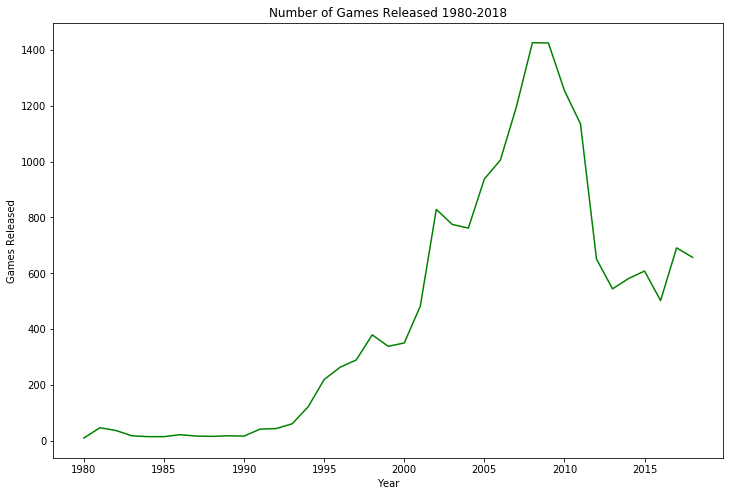

In [520]:
plt.figure(figsize=(12,8))
plt.title("Number of Games Released 1980-2018")
plt.xlabel('Year')
plt.ylabel('Games Released')
plt.plot(year_count['Year_of_Release'], year_count['Name'], color='green')
plt.show()

In [521]:
combined_df2['Platform'].value_counts()

PS2     2127
DS      2122
PS3     1315
Wii     1292
X360    1242
PSP     1194
PS      1190
PC      1005
PS4      896
GBA      811
XB       803
PSV      596
3DS      579
GC       542
XOne     520
N64      316
NS       256
SNES     239
SAT      173
WiiU     152
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
WS         6
SCD        6
3DO        3
TG16       2
GG         1
PCFX       1
Name: Platform, dtype: int64

In [522]:
year_sales = combined_df2.groupby('Year_of_Release', axis=0)['Global_Sales'].sum()

In [523]:
year_sales_df = pd.DataFrame(year_sales).reset_index()

In [524]:
year_sales_df

,Year_of_Release,Global_Sales
0,1980.0,11.38
1,1981.0,35.77
2,1982.0,28.86
3,1983.0,16.79
4,1984.0,50.36
5,1985.0,53.94
6,1986.0,37.07
7,1987.0,21.74
8,1988.0,47.22
9,1989.0,73.45


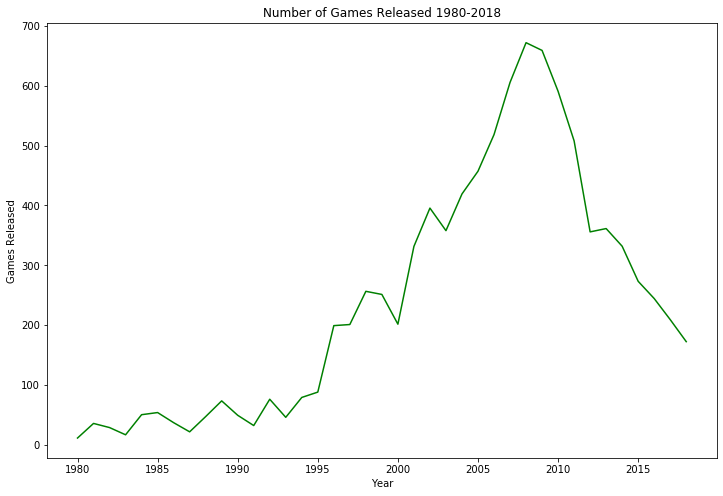

In [525]:
plt.figure(figsize=(12,8))
plt.title("Number of Games Released 1980-2018")
plt.xlabel('Year')
plt.ylabel('Games Released')
plt.plot(year_sales_df['Year_of_Release'], year_sales_df['Global_Sales'], color='green')
plt.show()

In [530]:
sum(list(combined_df2['Global_Sales']))

9318.530000001396

In [527]:
combined_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17791 entries, 0 to 17945
Data columns (total 16 columns):
Name               17791 non-null object
Platform           17791 non-null object
Year_of_Release    17791 non-null float64
Genre              17791 non-null object
Publisher          17791 non-null object
NA_Sales           17791 non-null float64
EU_Sales           17791 non-null float64
JP_Sales           17791 non-null float64
Other_Sales        17791 non-null float64
Global_Sales       17791 non-null float64
Critic_Score       8172 non-null float64
Critic_Count       7982 non-null float64
User_Score         7491 non-null float64
User_Count         7462 non-null float64
Developer          11250 non-null object
Rating             10614 non-null object
dtypes: float64(10), object(6)
memory usage: 2.3+ MB
